# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Integración-de-datos" data-toc-modified-id="Integración-de-datos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Integración de datos</a></div><div class="lev1 toc-item"><a href="#Definición-de-funciones" data-toc-modified-id="Definición-de-funciones-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Definición de funciones</a></div><div class="lev1 toc-item"><a href="#Análisis-a-64-km" data-toc-modified-id="Análisis-a-64-km-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Análisis a 64 km</a></div><div class="lev1 toc-item"><a href="#Analisis-a-32-km" data-toc-modified-id="Analisis-a-32-km-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analisis a 32 km</a></div><div class="lev1 toc-item"><a href="#Análisis-con-todos-para-64-y-32-km" data-toc-modified-id="Análisis-con-todos-para-64-y-32-km-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Análisis con todos para 64 y 32 km</a></div>

In [1]:
# Magics
%matplotlib inline

In [2]:
# Load libraries
from __future__ import print_function
from __future__ import division

import requests
import json

# Stats
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix


# GIS libs
import folium
import folium.plugins
import fiona # for reading and writing shapefiles
import geopandas as gpd

import os
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sns.set()

# Integración de datos

La primer tarea es extraer la información en el shape de IUCN y crear malla de presencia y ausencia para comparar los resultados de un modelo climático de SPECIES. Utilizaremos una resolución de 64km por lado de celda.

In [3]:
# cargamos la malla de Mexico
analysis_res = 64
grid_path = os.path.join("grids/", "mx_grid_{}km.json".format(analysis_res))
grid = gpd.read_file(grid_path)

In [4]:
grid.head()

,gridid,geometry
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...
1,43508,"POLYGON ((-116.1341999309717 30.1278936836953,..."
2,43913,"POLYGON ((-115.5592781491352 30.1278936836953,..."
3,44317,POLYGON ((-114.9843563672987 29.62939167656038...
4,41885,POLYGON ((-118.4338870583177 28.62497658989397...


In [5]:
# cargamos el mapa de IUCN
iucn_shp = gpd.read_file('data/IUCN/TERRESTRIAL_MAMMALS/TERRESTRIAL_MAMMALS.shp')

In [6]:
iucn_shp.head()

,id_no,binomial,presence,origin,seasonal,compiler,year,citation,source,dist_comm,...,order_,family,genus,code,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry
0,17175,Phyllonycteris poeyi,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,CHIROPTERA,PHYLLOSTOMIDAE,Phyllonycteris,LC,f,t,f,42.448583,9.302263,(POLYGON ((-84.41569999999996 22.1800355930000...
1,17175,Phyllonycteris poeyi,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,CHIROPTERA,PHYLLOSTOMIDAE,Phyllonycteris,LC,f,t,f,25.228298,6.356187,POLYGON ((-72.80069999999995 19.95113559300006...
2,17224,Phyllotis darwini,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,RODENTIA,CRICETIDAE,Phyllotis,LC,f,t,f,33.818170,12.434855,POLYGON ((-70.44139999999999 -23.7277644069999...
3,15783,Oxymycterus angularis,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,RODENTIA,CRICETIDAE,Oxymycterus,LC,f,t,f,34.727689,37.371101,POLYGON ((-43.45839999999998 -2.59556440699992...
4,15793,Oxymycterus hiska,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,RODENTIA,CRICETIDAE,Oxymycterus,LC,f,t,f,14.310056,2.899256,POLYGON ((-66.71369999999996 -16.1478644079999...


In [7]:
len(iucn_shp)

12546

In [ ]:
ax = grid.plot(color='blue')
iucn_shp.plot(ax=ax)

Una vez cargado el shape de IUCN necesitamos iterar sobre cada especie. Para cada especie obtenemos las celdas que ocupa y deberíamos agregar esas precencias a una mega PAM. La PAM tendrá un renglón por especie y una columna por celda (especies x celdas). Esta es una matriz dispersa (checar opciones para manejar este tipo de matrices p.ej en scypy). Los indices de la PAM los deberíamos mapear a nombres de especie y ids de celda

Nota: En MacOSX tuve que instalar rtree y spatialindex para que funcionara gpd.sjoin:
* pip install rtree
* brew install spatialindex

También hubo que reinstalar fiona y shapely desde código fuente porque aparecía el error: 
    
    Assertion failed: (0), function query, file AbstractSTRtree.cpp, line 285.
* pip install --no-binary :all: fiona
* pip install --no-binary :all: shapely

In [9]:
%time presence_cells = gpd.sjoin(grid, iucn_shp, op='intersects', how='left')

CPU times: user 1min 4s, sys: 478 ms, total: 1min 4s
Wall time: 1min 4s


In [35]:
presence_cells.head()

,gridid,geometry,index_right,id_no,binomial,presence,origin,seasonal,compiler,year,...,class,order_,family,genus,code,marine,terrestial,freshwater,Shape_Leng,Shape_Area
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,4231.0,41663.0,Taxidea taxus,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,CARNIVORA,MUSTELIDAE,Taxidea,LC,f,t,f,309.142318,971.013786
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,329.0,3745.0,Canis latrans,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,CARNIVORA,CANIDAE,Canis,LC,f,t,f,1075.987282,2143.776069
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,9302.0,14210.0,Myotis volans,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,CHIROPTERA,VESPERTILIONIDAE,Myotis,LC,f,t,f,346.334548,519.782825
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,8599.0,16672.0,Peromyscus maniculatus,1.0,1.0,1.0,IUCN,2009.0,...,MAMMALIA,RODENTIA,CRICETIDAE,Peromyscus,LC,f,t,f,811.214142,1524.249427
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,9138.0,42393.0,Odocoileus hemionus,1.0,1.0,1.0,IUCN,2009.0,...,MAMMALIA,CETARTIODACTYLA,CERVIDAE,Odocoileus,LC,f,t,f,392.101065,729.819443


Agrupamos por especie el DF de presencias

In [13]:
sp_cells = presence_cells.groupby(by='binomial')

In [14]:
iucn_data = sp_cells.get_group('Ammospermophilus interpres')
iucn_data.head()

,gridid,geometry,index_right,id_no,binomial,presence,origin,seasonal,compiler,year,...,class,order_,family,genus,code,marine,terrestial,freshwater,Shape_Leng,Shape_Area
21,54034,POLYGON ((-101.1862336032229 28.11911671800926...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
24,54031,POLYGON ((-101.1862336032229 26.58726561098146...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
25,54033,POLYGON ((-101.1862336032229 27.61085890614313...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
161,54035,POLYGON ((-101.1862336032229 28.62497658989397...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
183,54030,"POLYGON ((-101.1862336032229 26.0719904140863,...",6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569


Para cada especie tenemos un mapa que tomamos como la verdad sobre la distribución de la especie

CPU times: user 37.2 ms, sys: 339 µs, total: 37.5 ms
Wall time: 37.5 ms


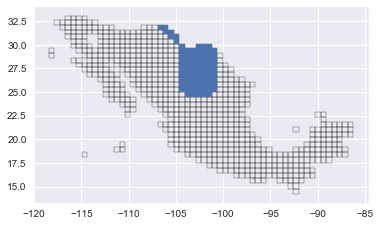

In [15]:
ax = grid.plot(facecolor='none', edgecolor='k')
iucn_data.plot(ax=ax)


In [17]:
url_api = 'http://species.conabio.gob.mx/api/niche/'
endpoint = 'getCellScore'
params = "id=27923&idtime=1525302357735&apriori=apriori&min_occ=5&fossil=false&mapa_prob=mapa_prob&sfecha=false&val_process=false&idtabla=no_table&grid_res=64&tfilters%5B0%5D%5Bvalue%5D=root_bioclim&tfilters%5B0%5D%5Btype%5D=0&tfilters%5B0%5D%5Blevel%5D=0&tfilters%5B0%5D%5Blabel%5D=Bioclim&tfilters%5B1%5D%5Bfield%5D=clasevalida&tfilters%5B1%5D%5Bvalue%5D=Mammalia&tfilters%5B1%5D%5Btype%5D=4&tfilters%5B2%5D%5Bfield%5D=clasevalida&tfilters%5B2%5D%5Bvalue%5D=Magnoliopsida&tfilters%5B2%5D%5Btype%5D=4&hasBios=true&hasRaster=true"

query = "{}{}?{}".format(url_api, endpoint, params)
r = requests.get(query)
data = json.loads(r.content)
data = data['data']
data = pd.DataFrame(data)

In [18]:
data.describe()

,gridid
count,1684.000000
mean,52599.232185
std,6181.927282
min,41863.000000
25%,47156.750000
50%,52409.500000
75%,57662.250000
max,64168.000000


In [19]:
sdm = grid.merge(data, on='gridid')
sdm.tscore = pd.to_numeric(sdm.tscore)
sdm.head()

,gridid,geometry,tscore
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,0.000000e+00
1,43508,"POLYGON ((-116.1341999309717 30.1278936836953,...",0.000000e+00
2,43913,"POLYGON ((-115.5592781491352 30.1278936836953,...",0.000000e+00
3,44317,POLYGON ((-114.9843563672987 29.62939167656038...,0.000000e+00
4,41885,POLYGON ((-118.4338870583177 28.62497658989397...,3.256122e-169


In [20]:
sdm_eval = sdm.merge(iucn_data[['gridid', 'presence']], on='gridid', how='left')
sdm_eval['presence'] = sdm_eval['presence'].fillna(0).astype(int)
sdm_eval['pred'] = sdm_eval['tscore'].round(0).astype(int)

sdm_eval['confussion'] = 2*sdm_eval['presence'] + sdm_eval['pred']
labels = {
    0: 'True negative',
    1: 'False possitive',
    2: 'False negative',
    3: 'True possitive'
}
sdm_eval['confussion_labels'] = [labels[conf_val] for conf_val in sdm_eval['confussion']]

In [21]:
sdm_eval[sdm_eval['confussion'] == 3].head()

,gridid,geometry,tscore,presence,pred,confussion,confussion_labels
24,54031,POLYGON ((-101.1862336032229 26.58726561098146...,1.0,1,1,3,True possitive
183,54030,"POLYGON ((-101.1862336032229 26.0719904140863,...",1.0,1,1,3,True possitive
184,54032,POLYGON ((-101.1862336032229 27.10023197012804...,1.0,1,1,3,True possitive
187,54029,POLYGON ((-101.1862336032229 25.55443784768825...,1.0,1,1,3,True possitive
205,54036,"POLYGON ((-101.1862336032229 29.1284105912999,...",1.0,1,1,3,True possitive


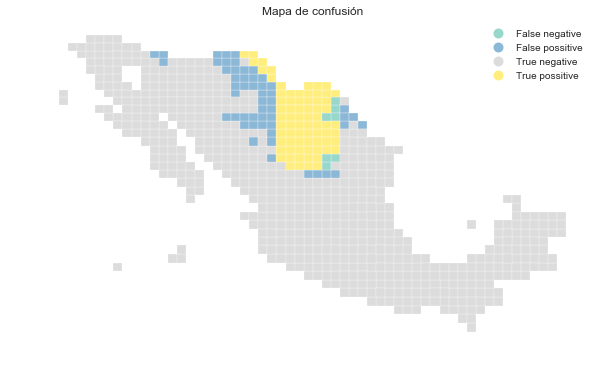

In [22]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title(u'Mapa de confusión')
sdm_eval.plot(ax=ax,
              column='confussion_labels',
              cmap='Set3',
              alpha=0.9,
              edgecolor='w',
              legend=True,
              categorical=True)
ax.set_axis_off()

In [23]:
print('Accuracy: ', accuracy_score(sdm_eval.presence, sdm_eval.pred))
print('F1 score: ', f1_score(sdm_eval.presence, sdm_eval.pred))
print('Recall: ', recall_score(sdm_eval.presence, sdm_eval.pred))
print('Precision: ', precision_score(sdm_eval.presence, sdm_eval.pred))
print('\n clasification report: \n', classification_report(sdm_eval.presence, sdm_eval.pred))
print('\n confussion matrix: \n',confusion_matrix(sdm_eval.presence, sdm_eval.pred))


Accuracy:  0.9198369565217391
F1 score:  0.7093596059113302
Recall:  0.9113924050632911
Precision:  0.5806451612903226

 clasification report: 
              precision    recall  f1-score   support

          0       0.99      0.92      0.95       657
          1       0.58      0.91      0.71        79

avg / total       0.94      0.92      0.93       736


 confussion matrix: 
 [[605  52]
 [  7  72]]


# Definición de funciones

In [24]:
api_url = 'http://species.conabio.gob.mx/api/niche'

In [25]:
def get_species_data(api_url, name, analysis_res=16):
    """ Regresa un dataframe con la información taxonomica de una especie y su id en la base de datos  """
    query = {
        "searchStr":name, # Nombre de la especie substring de la especie a buscar
        "source":1,        
        "limit": "true",
        "grid_res": 16
    }
    r = requests.post(api_url+'/especie/getEntList', params=query)

    response = json.loads(r.content)
    return pd.DataFrame(response['data'])

In [26]:
def get_sdm(api_url, sp_id, analysis_res=32):
    endpoint = 'getCellScore'
    params = params = {
        "id": "{}".format(sp_id),
        "lim_inf": "1940",
        "lim_sup": "2020",
        "idtime": "1525302357735",
        "apriori": "apriori",
        "min_occ": "5",
        "fossil": "false",
        "mapa_prob": "mapa_prob",
        "sfecha": "false",
        "val_process": "false",
        "idtabla": "no_table",
        "grid_res": "{}".format(analysis_res),
        "tfilters[0][value]": "root_bioclim",
        "tfilters[0][type]": "0",
        "tfilters[0][level]": "0",
        "tfilters[0][label]": "Bioclim",
        "tfilters[1][field]": "clasevalida",
        "tfilters[1][value]": "Mammalia",
        "tfilters[1][type]": "4",
        "tfilters[2][field]": "clasevalida",
        "tfilters[2][value]": "Magnoliopsida",
        "tfilters[2][type]": "4",
        "hasBios": "true",
        "hasRaster": "true"
    }
    query = api_url + "/{}".format(endpoint)
    r = requests.get(query, params)
    data = json.loads(r.content)
    data = data['data']

    data = pd.DataFrame(data)
    if data.empty:
        print('No data')
    else:
        data.tscore = pd.to_numeric(data.tscore)    
    
    return data


In [27]:
def evaluate_sdms(api_url, sp_cells, analysis_res = 64, start = 0, end = 20):
    sp_dfs = []
    labels = {
        0: 'True negative',
        1: 'False possitive',
        2: 'False negative',
        3: 'True possitive'
    }

    for sp in sp_cells.groups.keys()[start:end]:
        print(sp)
        truth = sp_cells.get_group(sp)
        species_data = get_species_data(api_url, sp, analysis_res)

        if {'spid'}.issubset(species_data.columns):
            spid = species_data['spid'][0]
            sdm = get_sdm(api_url, spid, analysis_res=analysis_res)
            if not sdm.empty:
                sdm = grid.merge(sdm, on='gridid')
                sdm['species'] = sp

                sdm_eval = sdm.merge(truth[['gridid', 'presence']], on='gridid', how='left')
                if {'tscore'}.issubset(sdm_eval.columns):
                    sdm_eval['presence'] = sdm_eval['presence'].fillna(0).astype(int)            
                    sdm_eval['pred'] = sdm_eval['tscore'].round(0).astype(int)
                    sdm_eval.loc[sdm_eval.presence > 2, 'presence'] = 0
                    sdm_eval.loc[sdm_eval.presence == 2, 'presence'] = 1
                    sdm_eval['confussion'] = 2*sdm_eval['presence'] + sdm_eval['pred']
                    sdm_eval['confussion_labels'] = [labels[conf_val] for conf_val in sdm_eval['confussion']]
                    sp_dfs.append(sdm_eval)
                    print("Numero de DFs: ", len(sp_dfs))
            
    return pd.concat(sp_dfs)

# Análisis a 64 km

In [28]:
analysis_res = 64

In [ ]:
%time sdms_df = evaluate_sdms(api_url, sp_cells)

In [31]:
print('Accuracy: ', accuracy_score(sdms_df.presence, sdms_df.pred))
print('F1 score: ', f1_score(sdms_df.presence, sdms_df.pred))
print('Recall: ', recall_score(sdms_df.presence, sdms_df.pred))
print('Precision: ', precision_score(sdms_df.presence, sdms_df.pred))
print('\n clasification report: \n', classification_report(sdms_df.presence, sdms_df.pred))
print('\n confussion matrix: \n',confusion_matrix(sdms_df.presence, sdms_df.pred))

Accuracy:  0.8084045584045584
F1 score:  0.7251175148170855
Recall:  0.9622999728776783
Precision:  0.5817347106082964

 clasification report: 
              precision    recall  f1-score   support

          0       0.98      0.75      0.85     10353
          1       0.58      0.96      0.73      3687

avg / total       0.88      0.81      0.82     14040


 confussion matrix: 
 [[7802 2551]
 [ 139 3548]]


In [36]:
flatui = ['#ca0020','#f4a582','#92c5de','#0571b0']
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

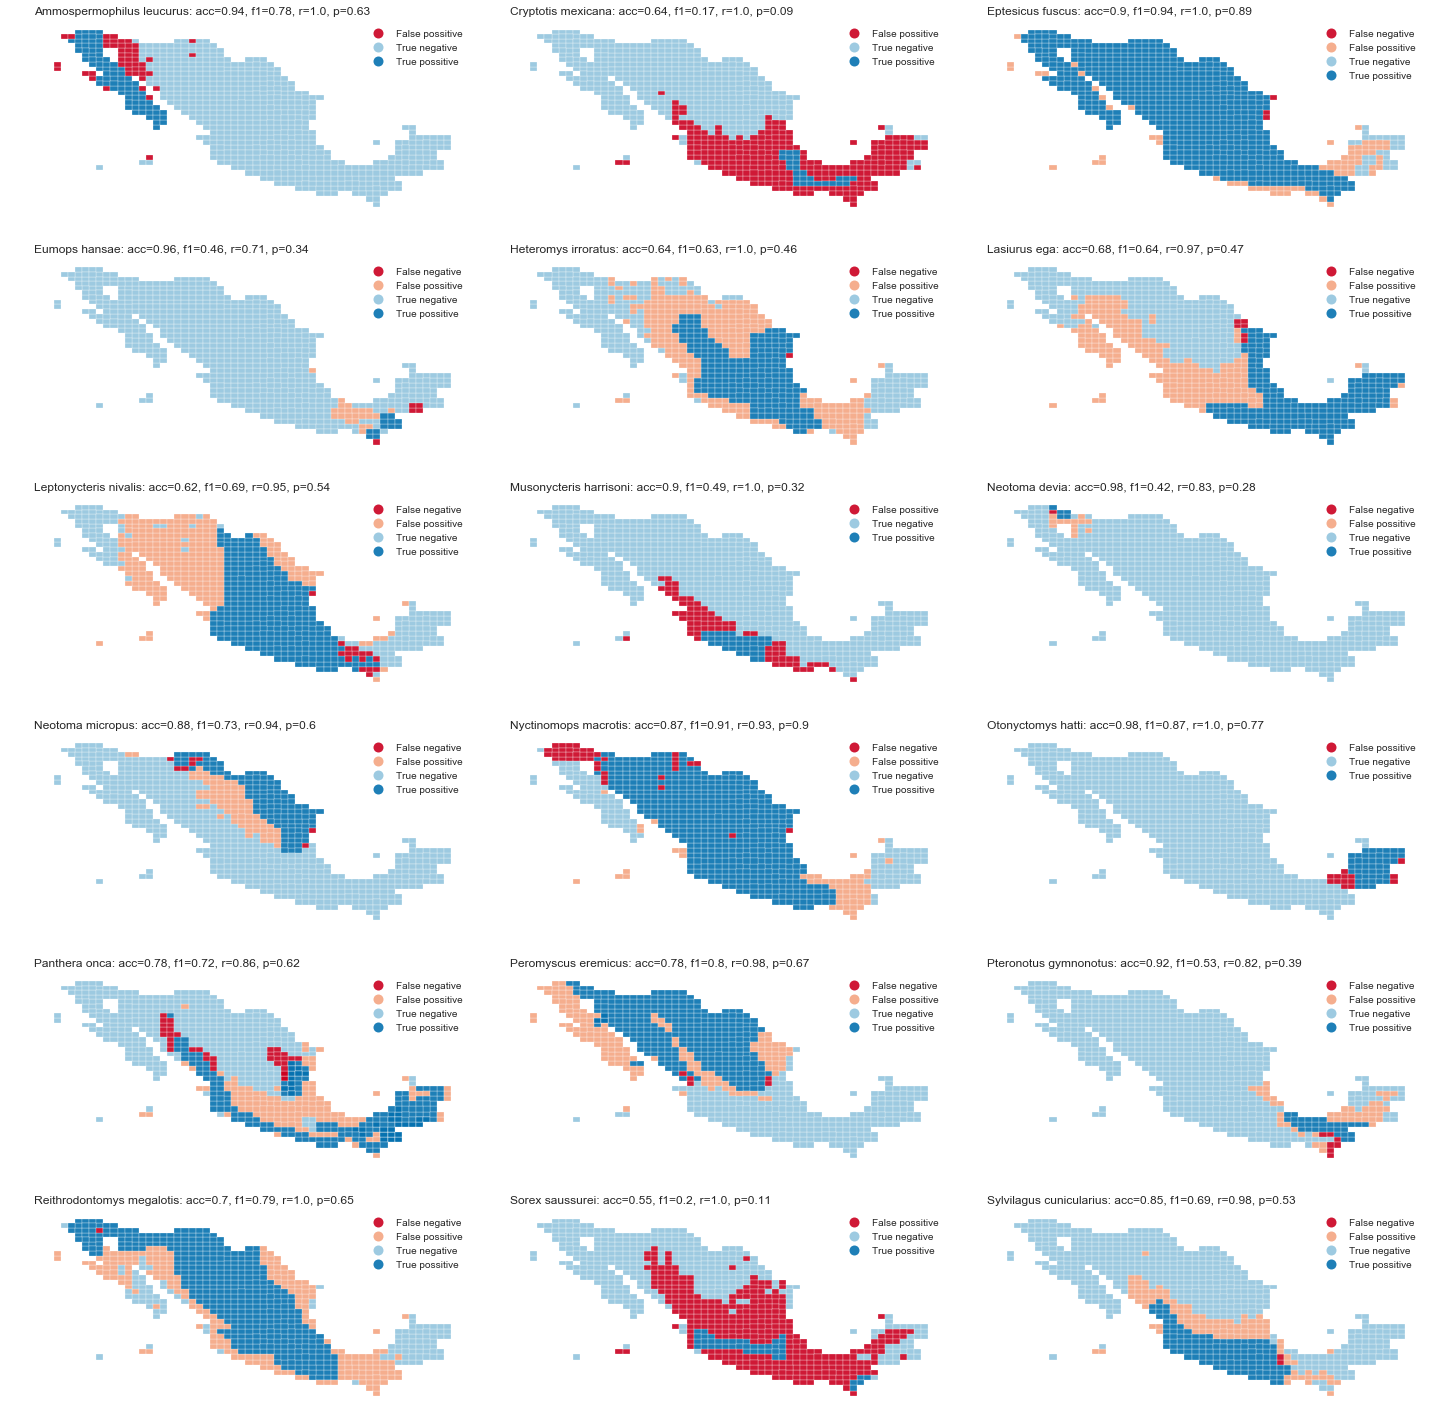

In [37]:
f, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))
sp_grp = sdms_df.groupby('species')

axes = axes.flat
ax_num = 0

stats = []
for name, grp in sp_grp:
    if ax_num >= len(axes):
        break
    ax = axes[ax_num]
    ax_num += 1
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    ax.set_title('{}: acc={}, f1={}, r={}, p={}'.format(
        name, round(acc, 2), round(f1, 2), round(recall, 2), round(prec, 2)), loc="left")
    
    stats.append((acc, 'acc'))
    stats.append((f1, 'f1'))
    stats.append((recall, 'recall'))
    stats.append((prec, 'precision'))
    
    grp.plot(ax=ax,
              column='confussion_labels',
              alpha=0.9,
              edgecolor='w',
              legend=True,
              categorical=True,
              cmap=my_cmap)
    ax.set_axis_off()

f.tight_layout()

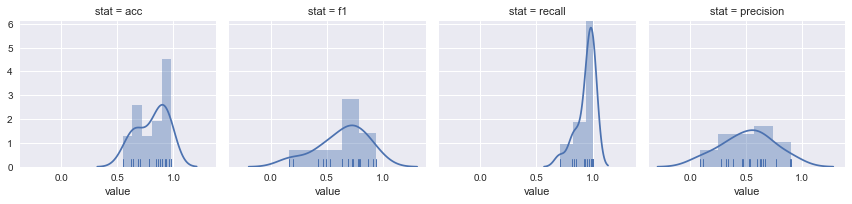

In [38]:
df = pd.DataFrame(stats, columns=['value', 'stat'])
g = sns.FacetGrid(df, col='stat')
g.map(sns.distplot, 'value', bins=5, kde=True, rug=True)

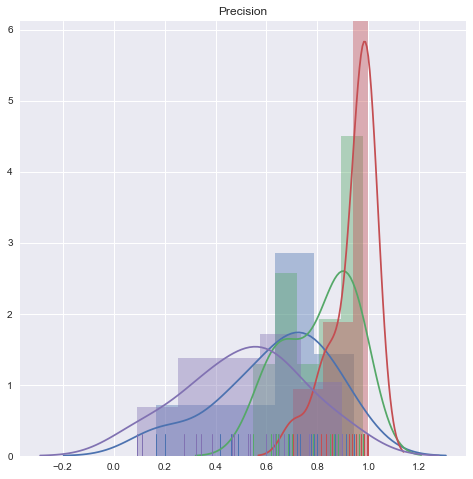

In [587]:
f, axes = plt.subplots(1, figsize=(8, 8))
ax = axes

ax.set_title("Score f1")
sns.distplot(f1s, bins=5, kde=True, rug=True, ax=ax);

ax.set_title("Accuracy")
sns.distplot(accs, bins=5, kde=True, rug=True, ax=ax);

ax.set_title("Recall")
sns.distplot(recalls, bins=5, kde=True, rug=True, ax=ax);

ax.set_title("Precision")
sns.distplot(precs, bins=5, kde=True, rug=True, ax=ax);

# Analisis a 32 km

In [49]:
analysis_res = 32

In [50]:
grid_path = os.path.join("grids/", "mx_grid_{}km.json".format(analysis_res))
grid = gpd.read_file(grid_path)
grid.describe()

,gridid
count,2639.000000
mean,3393.576355
std,1535.409959
min,49.000000
25%,2306.500000
50%,3388.000000
75%,4393.500000
max,6693.000000


In [51]:
%time presence_cells = gpd.sjoin(grid, iucn_shp, how='left', op='intersects')
sp_cells = presence_cells.groupby(by='binomial')

CPU times: user 3min 39s, sys: 731 ms, total: 3min 40s
Wall time: 3min 40s


In [ ]:
 %time sdms_df = evaluate_sdms(api_url, sp_cells, analysis_res, start = 0, end=20)

In [54]:
print('Accuracy: ', accuracy_score(sdms_df.presence, sdms_df.pred))
print('F1 score: ', f1_score(sdms_df.presence, sdms_df.pred))
print('Recall: ', recall_score(sdms_df.presence, sdms_df.pred))
print('Precision: ', precision_score(sdms_df.presence, sdms_df.pred))
print('\n clasification report: \n', classification_report(sdms_df.presence, sdms_df.pred))
print('\n confussion matrix: \n',confusion_matrix(sdms_df.presence, sdms_df.pred))

Accuracy:  0.825635103926097
F1 score:  0.7289048473967684
Recall:  0.9336293711838871
Precision:  0.5978167047473978

 clasification report: 
              precision    recall  f1-score   support

          0       0.97      0.79      0.87     37617
          1       0.60      0.93      0.73     12611

avg / total       0.88      0.83      0.84     50228


 confussion matrix: 
 [[29696  7921]
 [  837 11774]]


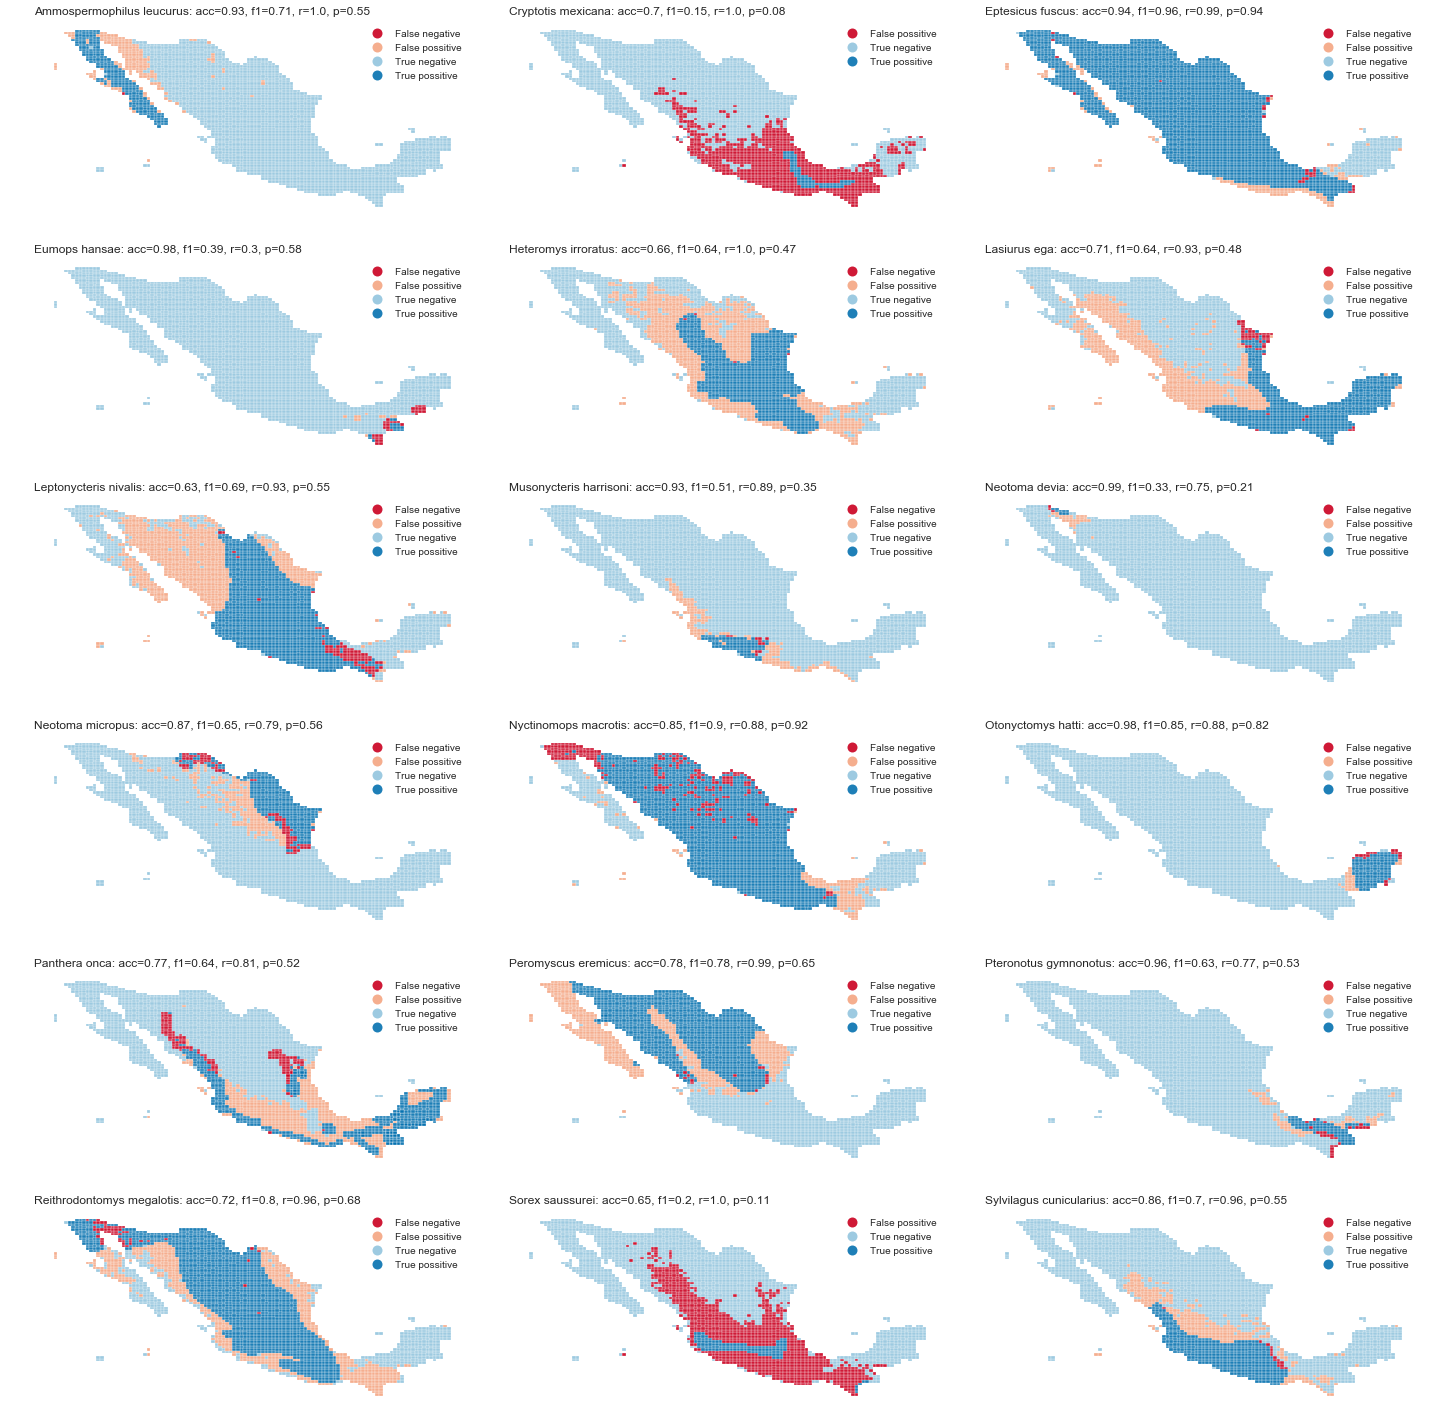

In [55]:
f, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))
sp_grp = sdms_df.groupby('species')

axes = axes.flat
ax_num = 0

stats = []
for name, grp in sp_grp:
    if ax_num >= len(axes):
        break
    ax = axes[ax_num]
    ax_num += 1
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    ax.set_title('{}: acc={}, f1={}, r={}, p={}'.format(
        name, round(acc, 2), round(f1, 2), round(recall, 2), round(prec, 2)), loc="left")
    
    stats.append((acc, 'acc'))
    stats.append((f1, 'f1'))
    stats.append((recall, 'recall'))
    stats.append((prec, 'precision'))
    
    grp.plot(ax=ax,
              column='confussion_labels',
              alpha=0.9,
              edgecolor='w',
              legend=True,
              categorical=True,
              cmap=my_cmap)
    ax.set_axis_off()

f.tight_layout()

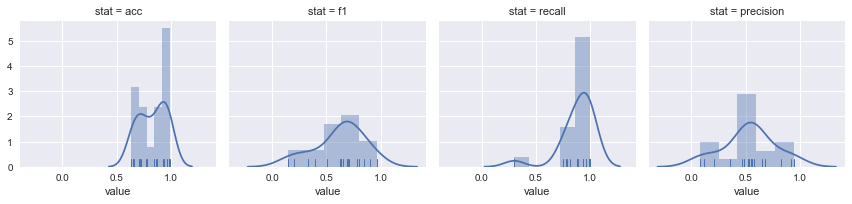

In [57]:
df = pd.DataFrame(stats, columns=['value', 'stat'])
g = sns.FacetGrid(df, col='stat')
g.map(sns.distplot, 'value', bins=5, kde=True, rug=True)

# Análisis con todos para 64 y 32 km

In [ ]:
analysis_res = 64

grid_path = os.path.join("grids/", "mx_grid_{}km.json".format(analysis_res))
grid = gpd.read_file(grid_path)

In [62]:
%time presence_cells = gpd.sjoin(grid, iucn_shp, how='left', op='intersects')
sp_cells = presence_cells.groupby(by='binomial')

CPU times: user 1min, sys: 156 ms, total: 1min
Wall time: 1min


In [ ]:
num_batches = len(sp_cells) // 10
%time sdms_df = evaluate_sdms(api_url, sp_cells, analysis_res, start = 0, end=10)

In [ ]:
for i in range(1, num_batches + 1):
    print(i)
    %time sdms_df = sdms_df.append(evaluate_sdms(api_url, sp_cells, analysis_res, start = 10 * i, end = 10 * (i + 1)))

Numero de DFs:  3
Enchisthenes hartii
Numero de DFs:  4
Chaetodipus nelsoni


In [ ]:
print('Accuracy: ', accuracy_score(sdms_df.presence, sdms_df.pred))
print('F1 score: ', f1_score(sdms_df.presence, sdms_df.pred))
print('Recall: ', recall_score(sdms_df.presence, sdms_df.pred))
print('Precision: ', precision_score(sdms_df.presence, sdms_df.pred))
print('\n clasification report: \n', classification_report(sdms_df.presence, sdms_df.pred))
print('\n confussion matrix: \n',confusion_matrix(sdms_df.presence, sdms_df.pred))

In [ ]:
sdms_df.confussion_labels = pd.Categorical(sdms_df.confussion_labels, labels.values(), ordered=False)

In [ ]:
f, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 40))
sp_grp = sdms_df.groupby('species')

axes = axes.flat
ax_num = 0

stats = []
for name, grp in sp_grp:
    if ax_num >= len(axes):
        break
    ax = axes[ax_num]
    ax_num += 1
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    ax.set_title('{}: acc={}, f1={}, r={}, p={}'.format(
        name, round(acc, 2), round(f1, 2), round(recall, 2), round(prec, 2)), loc="left")
    
    stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec})
    
    grp.plot(ax=ax,
              column='confussion_labels',
              alpha=0.9,
              edgecolor='w',
              legend=True,
              categorical=True,
              cmap=my_cmap)
    ax.set_axis_off()

f.tight_layout()

In [ ]:
stats = []
for name, grp in sp_grp:
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    
    stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec, 'name': name})

In [ ]:
df = pd.DataFrame(stats)
df.describe()

In [754]:
df[df.precision < 0.01]

,acc,f1,name,precision,recall
118,0.992800,0.000000,Geomys personatus,0.000000,0.0
126,0.993937,0.000000,Habromys chinanteco,0.000000,0.0
128,0.888973,0.013468,Habromys lepturus,0.006780,1.0
172,0.766199,0.009631,Megadontomys thomasi,0.004839,1.0
191,0.948086,0.000000,Molossus pretiosus,0.000000,0.0
229,0.996590,0.000000,Neotoma insularis,0.000000,0.0
289,0.995079,0.000000,Peromyscus guardia,0.000000,0.0
423,0.892383,0.013889,Tylomys bullaris,0.006993,1.0
425,0.883289,0.019108,Tylomys tumbalensis,0.009646,1.0
